# Import

In [2]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
import math
# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)
import random
import datetime
import shutil
print("TensorFlow version: {}".format(tf.__version__))
import random
from importlib import reload
import PINN  # python files (classes)
import pre_post
from pre_post import *
from PINN import *

2023-04-04 17:17:28.942534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 17:17:29.023237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 17:17:29.023253: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-04 17:17:29.440009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

TensorFlow version: 2.11.0


# Resolution of a Phase-Field problem using PINN : Traveling wave 


## Theory

The Gibbs free energy of a multi-phase-field (MPF) system could be seen (from a first approach) as a summation of an interfacial free energy density [$J.m^{-3}$] (also called Grain-Boundary (GB)) $f^{GB}$ and a chemical one $f^{chem}$ as follows.  

$F = \int_\Omega f^{GB} + f^{chem}$



The other contributions could be added added to the MPF free energy forumaltuion, such as the mechanical ($f^{chem}$) and magnetic ones.

$f^{GB} = \int _{\alpha,\beta=1..N,\alpha > \beta} \frac{4\sigma_{\alpha\beta}}{\eta} \Bigm\{ -\frac{\eta^2}{\pi^2} \nabla\phi_\alpha \cdot \nabla\phi_\beta  + \phi_\alpha \phi_\beta \Bigm\}$

 $\phi_\alpha$ is is the non-conservative phase-field variable corresponding to the phase $\alpha$ (idem for $\beta$), N is the number of components/crysals present in the system, $\sigma_{\alpha\beta}$ is the interfacial energy while $\eta$ is the intrface width.     

For a system with two-phases (binary), the previous expression becomes:

$f^{GB} =  \frac{4\sigma_{}}{\eta} \Bigm\{ -\frac{\eta^2}{\pi^2} \nabla\phi_ \cdot \nabla(1-\phi_)  + \phi (1-\phi ) \Bigm\}$

or simply:

$f^{GB} =  \frac{4\sigma_{}}{\eta} \Bigm\{\phi (1-\phi )+ \frac{\eta^2}{\pi^2} (\nabla\phi) ^{2}  \Bigm\}$

Th temporal evolution of the non-conserved order parameter $\phi$ follows the Allen-Cahn formualtion :

$\frac{\partial \phi}{\partial t}=-L. \frac{\delta F}{\delta \phi}$

where $L$ is the kinetic coefficient of the interface.

in 1D, for a dual interface ($f^{GB}$ is noted hereafter $f^{int}$), when considereing only the interfacial energy $F = \int_\Omega f^{int} dx$, the AC formulation gives:

$\frac{\partial \phi}{\partial t}=-L \Bigm\{ \frac{\partial f^{int}}{\partial \phi} - \nabla \cdot \frac{\partial f^{int}}{\partial (\nabla \phi)} \Bigm\}$

$\frac{\partial \phi}{\partial t} = L \Bigg( \frac{4\sigma}{\eta} \bigg[ (2\phi - 1 )+ 2 \frac{\eta^2}{\pi^2} \nabla^2 \phi \bigg] \Bigg)$

This expression could be also expressed as :

$\dot{\phi}=\mu \sigma\left(\nabla^2 \phi+\frac{\pi^2}{2 \eta^2}(2 \phi-1)\right)$

where: $\mu=\frac{8\eta L}{\pi^{2}} $

$[\mu] = \frac{\text{L}^4}{\text{T}}E $   : $    {m}^4{J}^{-1}{s}^{-1}$

$[\sigma] = \frac{\text{E}}{\text{L}^2}$  : $    {J}^{}{m}^{-2}$

$[L] =  {m}^3{J}^{-1}{s}^{-1}$

We should note that the previous developements concern only the interface contrubution. However, in order to garantee a moving interface, the non interfacial contributions should be taken into account: 

$f^{dual}=f^{int} + h(\phi) \Delta g$

$[\Delta g] =  {m}{s}^{-1}$


where $h(\phi)$ is a coupling function between $0$ and $1$ monotonous in $\phi$ in the range between $0$ and $1$ chosen in order to ensure a traveling wave solution. 
$\Delta g$ corresponds to the non-interfacial free enegry densities. 


$h(\phi) = \frac1\pi[(4\phi-2)\sqrt{\phi(1-\phi)} + arcsin(2\phi-1)]$

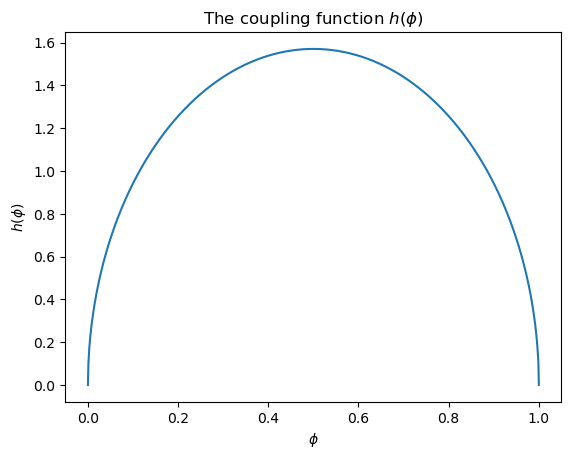

In [3]:
# Define the function h(phi)
def h(phi):
    return (np.pi) *  np.sqrt(phi*(1-phi))

# Create an array of phi values between 0 and 1
phi_values = np.linspace(0, 1, 1000)

# Evaluate the function h(phi) for the phi values
h_values = h(phi_values)

# Plot h(phi) as a function of phi
plt.plot(phi_values, h_values)
plt.xlabel('$\phi$')
plt.ylabel('$h(\phi)$')
plt.title('The coupling function $h(\phi)$')
plt.show()

$\frac\partial  {\partial\phi} h(\phi) = \frac8\pi \sqrt{\phi(1-\phi)}$

### Main equation

$\Rightarrow$ The evolution of the order parameter with respect to time is described by this equation: 

$\dot{\phi}=\mu \left[ \sigma\left(\nabla^2 \phi+\frac{\pi^2}{2 \eta^2}(\phi-\frac{1}{2})\right) +h(\phi) \Delta g \right] $

where the left side descrive the interfacial changes while the right one controls the moving of the interface

### Plot of the analatyical solution

In order to validate a first PINN solution using AC, we take first the exact solution in 1D:

\begin{equation}
\phi(x, t)=\left\{\begin{array}{lll}
1 & \text { for } & x<v_n t-\frac{\eta}{2} \\
\frac{1}{2}-\frac{1}{2} \sin \left(\frac{\pi}{\eta}\left(x-v_n t\right)\right) & \text { for } & v_n t-\frac{\eta}{2} \leq x<v_n t+\frac{\eta}{2} \\
0 & \text { for } & x \geq v_n t+\frac{\eta}{2}
\end{array}\right.
\end{equation}

where $v_n$ is the interface velocity or the velocity of the wave traveling in positive x direction

#### Model inputs

In [4]:
dx_=1e-7 
eta_=1 
Nx=1000
sigma_=1
mu_=1e-6
v_n=0.5
delta_g=5e5

#### Scaling the input parameters

In [5]:
def scale_params(dx, eta, sigma, mu, v):
    dx_scaled = dx #* 1e7
    eta_scaled = eta #* (1e7/5)
    sigma_scaled = sigma #* 1
    mu_scaled = mu #* 1e14
    v_scaled = v #* (1/5e-3)
    
    return dx_scaled, eta_scaled,sigma_scaled, mu_scaled, v_scaled

In [6]:
dx, eta, sigma, mu, v_n = scale_params(dx_, eta_, sigma_, mu_, v_n)

print("Scaled dx: ", dx)
print("Scaled eta: ", eta)
print("Scaled sigma: ", sigma)
print("Scaled mu: ", mu)
print("Scaled v: ", v_n)

Scaled dx:  1e-07
Scaled eta:  1
Scaled sigma:  1
Scaled mu:  1e-06
Scaled v:  0.5


### Theoretical solution

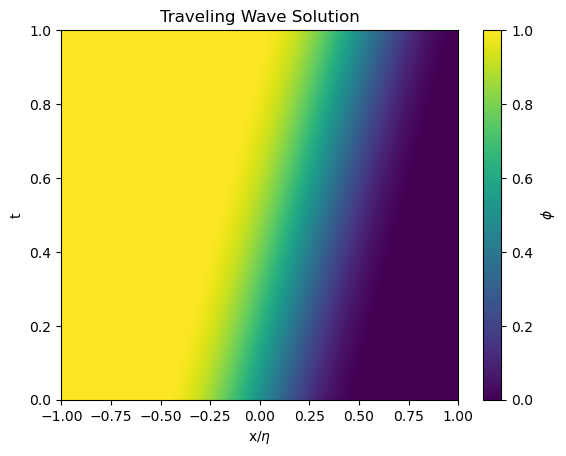

In [7]:
# Define the traveling wave function
def phi(x, t):
    phi_values = np.where(x < v_n*t - eta/2, 1.0,
                    np.where(x < v_n*t + eta/2, 0.5 - 0.5*np.sin(np.pi/eta*(x - v_n*t)), 0.0))
    return phi_values

# Define the range of values for x and t
x_range = np.linspace(-1, 1, Nx)
t_range = np.linspace(0, 1, Nx)

# Create a meshgrid of x and t values
x, t = np.meshgrid(x_range, t_range)

# Evaluate the traveling wave function for all x and t values
phi_true = phi(x, t)

# Create a 2D plot of phi as a function of t and x
plt.imshow(phi_true/eta, extent=[x_range[0], x_range[-1], t_range[0], t_range[-1]], origin='lower', aspect='auto')
plt.colorbar(label='$\phi$')
plt.xlabel(r'x/$\eta$')
plt.ylabel('t')
plt.title('Traveling Wave Solution')
plt.show()

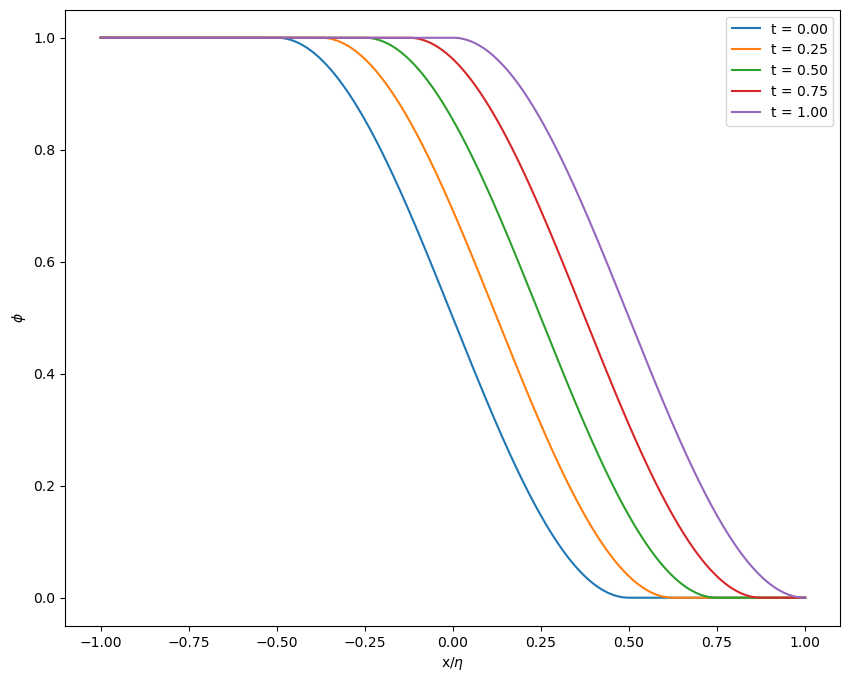

In [8]:
# Traveling wave solution
dt = 0.25
t_intervals = [0, dt, 2*dt, 3*dt, 5*dt]

# Create the subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate over the time intervals and plot the solution in the same graph
for i in range(5):
    # Find the index of the current time interval
    t_idx = np.argmin(np.abs(t_range - t_intervals[i]))

    # Evaluate the traveling wave function for the current time interval
    phi_ = phi(x_range, t_range[t_idx])

    # Plot the solution in the same graph with different color
    ax.plot(x_range/eta, phi_, label='t = {:.2f}'.format(t_range[t_idx]))

# Add axis labels and legend
ax.set_xlabel(r'x/$\eta$') 
ax.set_ylabel('$\phi$')
ax.legend()

# Show the plot
plt.show()

# --------------------------------------------------------------------------------------------------------------------------------------- Numerical Implementation ---------------------------------------------------------------------------------------------------------------------------------

In [9]:
x = np.linspace(-1, 1, 1000)
x=np.expand_dims(x, axis=1)
t = np.linspace(0, 1, 1000)
t=np.expand_dims(t, axis=1)

In [10]:
# define  Collocations points
N_ini = 50  #Total number of data points for 'u': IC
N_f = 10000   #Total number of collocation points : domain
N_b=100    # Total number of data points for 'u': boundary BC

In [11]:
X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
lb = np.array([x.min(), t.min()])  # Domain bounds
ub = np.array([x.max(), t.max()])  # Domain bounds
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
X_flat = X.flatten()
T_flat = T.flatten()

In [12]:
#data = scipy.io.loadmat('AC.mat')  	# Load data from file
phi_sol =   phi_true #data['uu'][::2,::2] 
sample_indices = np.random.choice(len(X_flat), size=N_b, replace=False)

Text(0.5, 1.0, 'Exact solution')

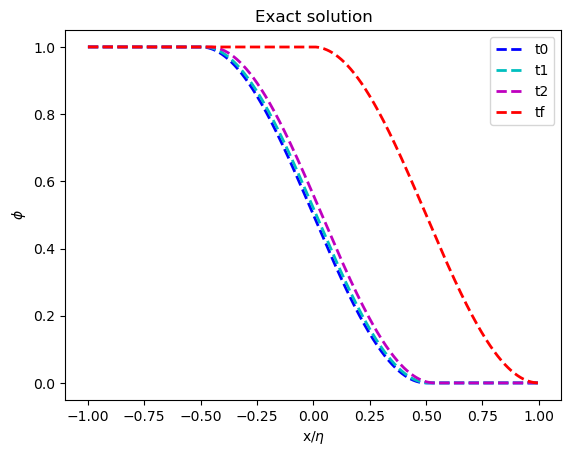

In [13]:
# to check how the evolution should be 
plt.plot(x/eta,phi_sol[0,:], 'b--', linewidth = 2, label = 't0')   
plt.plot(x/eta,phi_sol[25,:], 'c--', linewidth = 2, label = 't1')   
plt.plot(x/eta,phi_sol[75,:], 'm--', linewidth = 2, label = 't2')  
plt.plot(x/eta,phi_sol[-1,:], 'r--', linewidth = 2, label = 'tf')   
plt.legend()
plt.xlabel(r'x/$\eta$')
plt.ylabel(r'$\phi$')
plt.title("Exact solution")

In [14]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
# prepare the testing matrix
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) 


In [15]:
# prepare the training data
reload(pre_post) 
from pre_post import *
Pre_Post=PrePost( X=X,T=T, lb=lb, ub=ub, x=x, eta=eta)
X_f_train, X_ini_train,X_lb_train,X_ub_train,phi_ini_train=Pre_Post.set_training_data(N_ini,N_f,tb,eta,x)

X_f_train: (10000, 2), X_ini_train: (50, 2), X_lb_train: (100, 2), X_ub_train: (100, 2), u_ini_train: (50, 1)


In [ ]:
# plt.plot(X_obs_train[:,1], X_obs_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 100')
plt.plot(X_ini_train[:,1], X_ini_train[:,0], '*', color = 'b', markersize = 5, label = 'IC' )
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.7, label = 'PDE')
plt.plot(X_lb_train[:,1], X_lb_train[:,0], '*', color = 'g', markersize = 5, label = 'BC')
plt.plot(X_ub_train[:,1], X_ub_train[:,0], '*', color = 'm', markersize = 5, label = 'BC')

plt.xlabel('t', fontsize = 20)
plt.ylabel('x', fontsize = 20)
plt.tick_params(labelsize=20)
plt.legend(bbox_to_anchor=(0.6, 0.95), loc='upper left', fontsize = 20)
plt.show()


In [ ]:
Pre_Post.plot_Collocation_IC_BC(X_ini_train,X_f_train,X_lb_train,X_ub_train)

Text(0, 0.5, '$\\phi_0$')

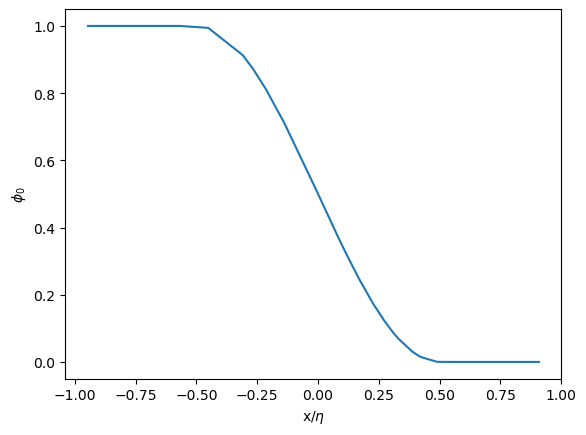

In [18]:
# check step
plt.plot(X_ini_train[:,0], phi_ini_train)
plt.xlabel(r'x/$\eta$')
plt.ylabel(r'$\phi_0$')

In [19]:
def EraseFile(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [20]:
global pathOutput
pathOutput = os.getcwd() + '/save_figs'
if not os.path.isdir(pathOutput):
    os.mkdir(pathOutput)

#### Train PINN

In [22]:
EraseFile(pathOutput)

import PINN
reload(PINN)  # mandatory to reload content at each re-call atfer modification
from PINN import *

layers = np.array([2,32,32,32,32,1]) 

PINN = Sequentialmodel(layers=layers, X_f_train=X_f_train, X_ini_train=X_ini_train,\
                        X_lb_train=X_lb_train, X_ub_train=X_ub_train,\
                              phi_ini_train=phi_ini_train, X_u_test=X_u_test,\
                                  X=X,T=T,x=x,lb=lb, ub=ub, mu=mu, sigma=sigma, delta_g=delta_g,\
                                      eta=eta)
Nfeval = 1
start_time = time.time() 

# train the model with Scipy L-BFGS optimizer

list_loss, results= PINN.train(epochs=1000,batch_size=512,thresh= 5e-5,epoch_scipy_opt=500,epoch_print=100,\
                               resample=False,initial_check=True,save_reg_int=True,num_train_intervals=20,moving_IC=False,path=pathOutput)

elapsed = time.time() - start_time                

print("Training time : " + (str(datetime.timedelta(seconds=elapsed))) ) 

Epoch: 0, total_loss: 1.446e+00, loss_BC: 4.734e-01, loss_IC: 1.822e-01, loss_f: 7.906e-01
Epoch: 100, total_loss: 3.998e-02, loss_BC: 2.103e-03, loss_IC: 7.294e-03, loss_f: 3.059e-02
Epoch: 200, total_loss: 2.523e-02, loss_BC: 1.407e-04, loss_IC: 8.656e-04, loss_f: 2.423e-02
Epoch: 300, total_loss: 1.791e-02, loss_BC: 9.883e-06, loss_IC: 8.386e-04, loss_f: 1.706e-02
Epoch: 400, total_loss: 1.522e-02, loss_BC: 1.598e-06, loss_IC: 2.290e-03, loss_f: 1.293e-02
Epoch: 500, total_loss: 1.408e-02, loss_BC: 4.625e-07, loss_IC: 3.519e-03, loss_f: 1.056e-02


!!! Scipy optimize: !!! - Epoch:  500
==> loss after L-BFGS-B optimization for Epoch: 500, total_loss: 7.070e-07, loss_BC: 2.123e-11, loss_IC: 5.966e-09, loss_f: 7.010e-07
!!! Scipy optimization done !!!
 
change the time domain to:  t_min: 0.000, t_max: 0.100
Epoch: 600, total_loss: 8.021e-07, loss_BC: 6.089e-32, loss_IC: 7.352e-09, loss_f: 7.948e-07
change the time domain to:  t_min: 0.000, t_max: 0.150
Epoch: 700, total_loss: 7.362e-07

In [ ]:
#print(results)

#PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)
print(u_pred.shape)

#error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
#print('Test Error: %.5f'  % (error_vec))

#u_pred = np.reshape(u_pred,(256,100),order='F')                        # Fortran Style ,stacked column wise!

(1000000, 1)


### Model inference

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


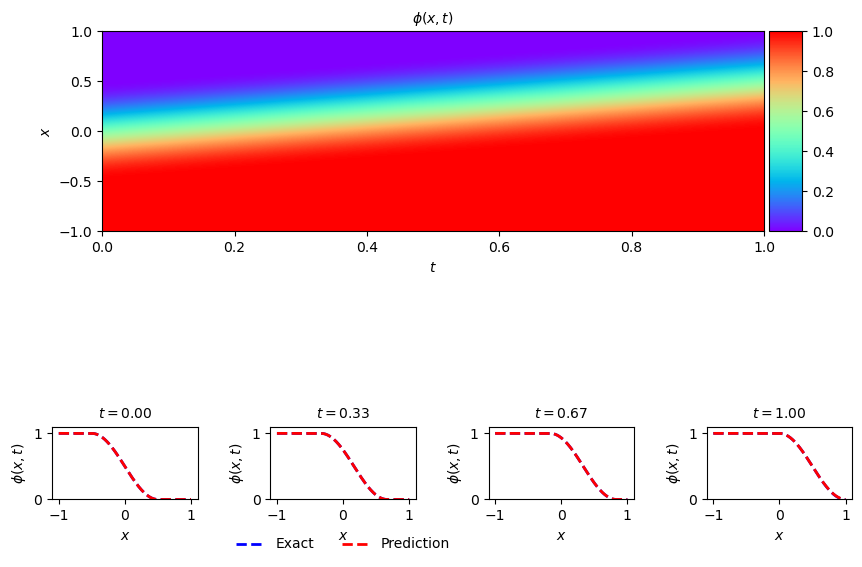

In [115]:
# only in debug execution 
reload(pre_post) 
from pre_post import *
Pre_Post=PrePost( X=X,T=T, lb=lb, ub=ub, x=x, eta=eta)
''' Solution Plot '''

u_pred = np.reshape(u_pred,(1000 ,1000),order='F')   
Pre_Post.solution_plot(u_pred=u_pred,phi_sol=phi_sol)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '$\\phi(x,t)$')

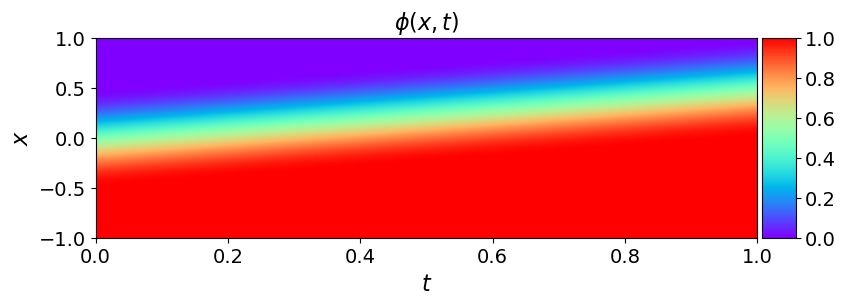

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
#######  gs0 
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1, bottom=0.8, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
            extent=[T.min(), T.max(), X.min(), X.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(X.min(), X.max(), 2)[:,None]
ax.tick_params(labelsize=14)
cax.tick_params(labelsize=14)
ax.set_xlabel('$t$', fontsize = 16)
ax.set_ylabel('$x$', fontsize = 16)
ax.legend(frameon=False, loc = 'best')
ax.set_title(r'$\phi(x,t)$', fontsize = 16)

In [36]:
# minor check
u_pred.shape,phi_sol.shape

((100, 100), (100, 100))

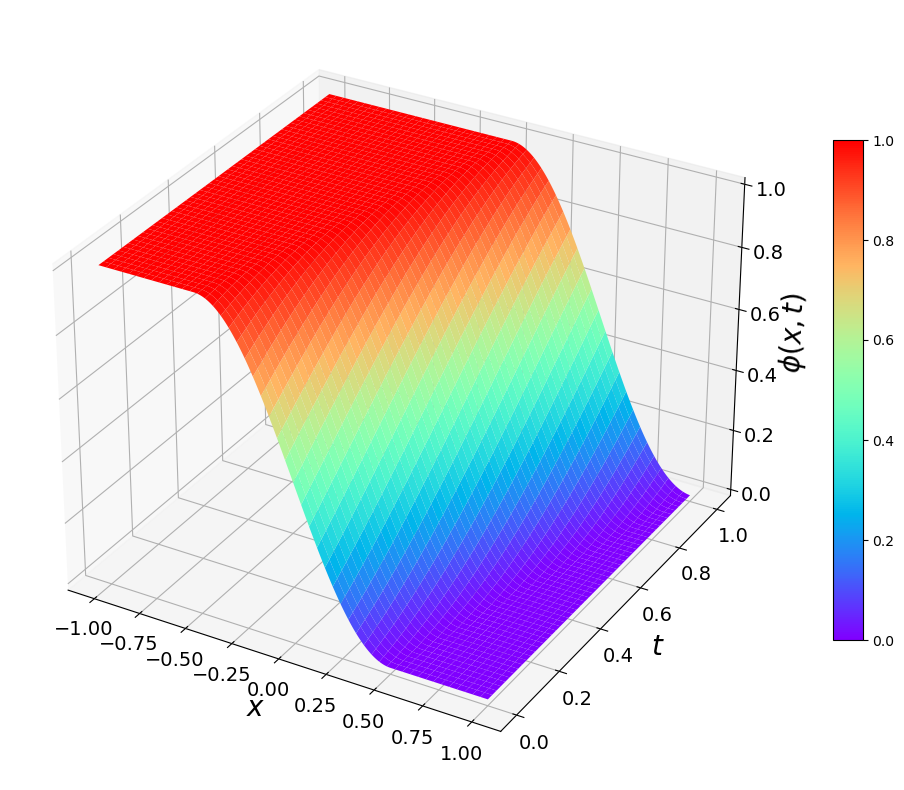

In [158]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data as a surface plot
surf = ax.plot_surface(X, T, u_pred.T, cmap='rainbow', vmin=0, vmax=1, linewidth=0.1)

# Customize the plot
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$t$', fontsize=20)
ax.set_zlabel(r'$\phi(x,t)$', fontsize=20)
ax.tick_params(labelsize=14)
# Add colorbar
cax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
h = plt.colorbar(surf, cax=cax, shrink=0.01)


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '$\\phi(x,t)_{pred}-\\phi(x,t)_{sol}$')

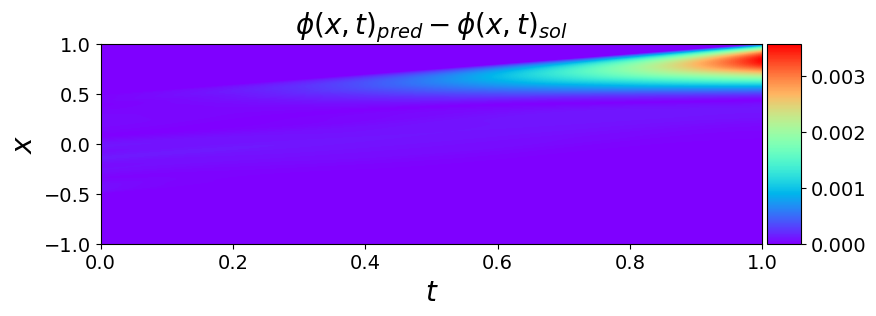

In [118]:
# error between exact and theroretical solution
error=np.abs(u_pred- phi_sol.T)
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
#######  gs0 
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1, bottom=0.8, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
h = ax.imshow(error, interpolation='nearest', cmap='rainbow', 
            extent=[T.min(), T.max(), X.min(), X.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax, )
line = np.linspace(X.min(), X.max(), 2)[:,None]
ax.tick_params(labelsize=14)
cax.tick_params(labelsize=14)
ax.set_xlabel('$t$', fontsize = 20)
ax.set_ylabel('$x$', fontsize = 20)
ax.legend(frameon=False, loc = 'best')
ax.set_title(r'$\phi(x,t)_{pred}-\phi(x,t)_{sol}$', fontsize = 20)

In [53]:
error_vec = np.linalg.norm((phi_sol-u_pred),2)/np.linalg.norm(phi_sol,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

Test Error: 0.64104


### Loss evolution

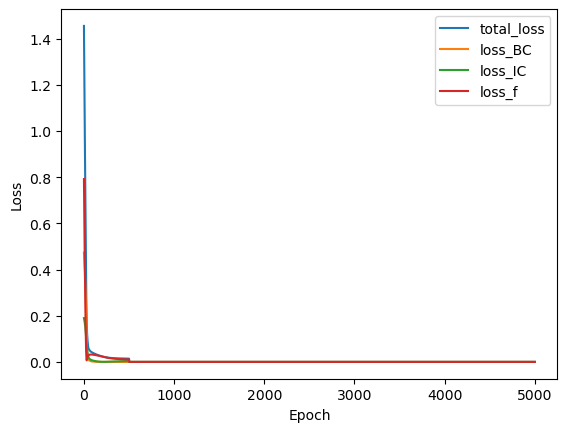

In [54]:
Pre_Post.plot_loss(list_loss=list_loss[:])

#### Track the interfacial velocity

In [87]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([0.2, 0.4999, 0.5555, 0.500001, 0.7])

# Define the tolerance for closeness to 0.5
tolerance = 0.01

# Find the index where y is close to 0.5 within the tolerance
tolerance = 0.01
mask = np.isclose(y, 0.5, rtol=tolerance, atol=tolerance)
index = np.argmax(mask)

print(index) 

1


68

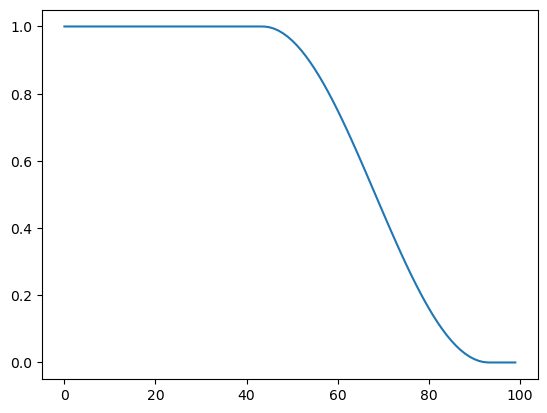

In [88]:
plt.plot(u_pred[:,t_idx])
tolerance = 0.01
mask = np.isclose(u_pred[:,t_idx] , 0.5, rtol=tolerance, atol=tolerance)
index = np.argmax(mask)
index

(0.0, 1.0)

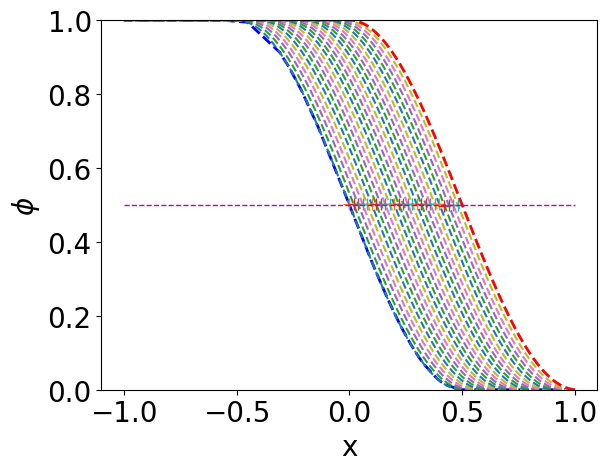

In [127]:
Nx=1000
Nt=1000
phi_pred = PINN.evaluate(X_u_test)
dim=phi_pred.shape[0]// Nx
phi_pred = np.reshape(phi_pred,( Nx,Nt),order='F')  
#------------------------------------
# for real time control (show predictions)
plt.figure() 
n_intervals = 25
t_step = Nt // n_intervals

plt.plot(X_ini_train[:,0],phi_ini_train[:,0],'b--', linewidth = 2, label = "u_ini_true")

list_vn=[]
for i in range(n_intervals):
    t_idx = i * t_step
    label = 't_{}'.format(t_idx) + "_pred"
    plt.plot(x, phi_pred[:,t_idx], '--',label=label)  

    # Find the index where phi equals 0.5
    diff = np.abs(phi_pred[:, t_idx] - 0.5)  
    if i>=0:
        index = np.argmin(diff)
        #print(index)
    list_vn.append([t_idx,x[index]])       

    # Add a cross at the position of the index
    plt.plot(x[index], phi_pred[index, t_idx], '+', markersize=8 )
    
color_ = tuple(np.random.rand(3))
plt.plot(x, phi_pred[:,-1], 'r--', linewidth=2, label='t_f')
plt.plot(x, [0.5]*len(x),'m--', linewidth=1)
plt.xlabel('x', fontsize = 20)
plt.ylabel(r'$\phi$', fontsize = 20)
plt.tick_params(labelsize=20)
plt.ylim(0, 1)
#plt.legend()    

#### identify the theoretical velocity
##### NB: to get the exact theoretical velocity $v_n$=5, a bit more re-training is required (up to 10 minutes - 2000 epochs).

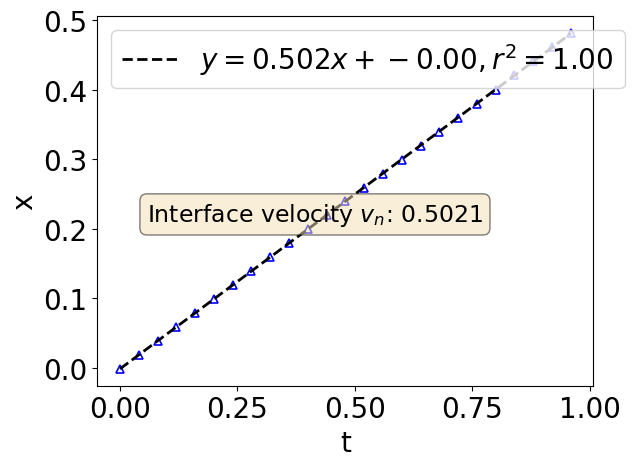

In [128]:
tt = np.asarray([item[0]/Nt for item in list_vn])
x_tt = np.asarray([item[1] for item in list_vn])
#print(tt.shape,x_tt.shape)
####
def Reg(x,y,xlab="t",ylab="x"):
    import scipy.stats as stats
    m,c,r,p,se1=stats.linregress(x,y)
    cm1lab="$"+('y=%2.3fx+%2.2f, r^2=%1.2f'%(m,c,r**2))+"$";
    plt.plot(x,y,'^',mfc='none',mec='b',mew=1.2)
    plt.plot(x, m*x+c,'k--',linewidth=2,label=cm1lab)
    plt.xlabel('t', fontsize = 20)
    plt.ylabel('x', fontsize = 20)
    plt.tick_params(labelsize=20)
    textstr = r'Interface velocity $v_n$: {:.4f}'.format(m)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.1, 0.5, textstr, transform=plt.gca().transAxes, fontsize=17,
        verticalalignment='top', bbox=props)
    plt.legend( loc='upper left', fontsize = 20)

#### CALL THE FUNCTION TO GET THE FIGURE
Reg(tt,np.squeeze(x_tt,1))

### Transfer the learning to a larger domain

In [36]:
x_2 = np.linspace(-10, 10, 1000)
x_2=np.expand_dims(x_2, axis=1)
t_2 = np.linspace(0, 10, 1000)
t_2=np.expand_dims(t_2, axis=1)

In [37]:
X_2, T_2= np.meshgrid(x_2,t_2)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
X_2_flat = X_2.flatten()
T_2_flat = T_2.flatten()

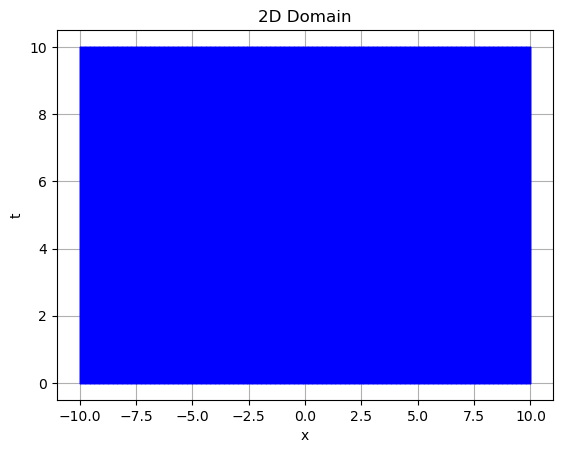

In [38]:
# plot 2D domain
plt.figure()
plt.plot(X_2, T_2, 'b-', linewidth=1)
plt.xlabel('x')
plt.ylabel('t')
plt.title('2D Domain')
plt.grid()
plt.show()

In [39]:
X_u_2_test = np.hstack((X_2.flatten()[:,None], T_2.flatten()[:,None])) 

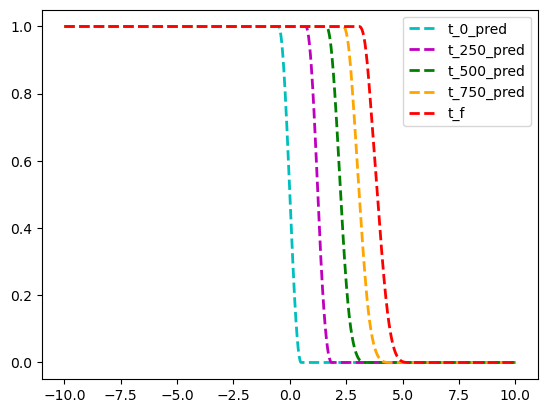

In [40]:
u_pred_2 = PINN.evaluate(X_u_2_test)
#dim=u_pred_2.shape[0]// 1000
u_pred_2  = np.reshape(u_pred_2 ,(1000,1000),order='F')  # 10 time intervals
#------------------------------------
# plot
# for real time control (show predictions)
plt.figure() 
n_intervals = 4
t_step = len(u_pred_2.T) // n_intervals


for i in range(n_intervals):
    color_ =['c','m','g','orange']
    t_idx = i * t_step
    x_p=np.linspace(-10,10,len(u_pred_2.T[t_idx, :]))
    label = 't_{}'.format(t_idx)+"_pred"
    plt.plot(x_p, u_pred_2.T[t_idx, :], '--', linewidth=2,color=color_[i], label=label)            
color_ = tuple(np.random.rand(3))
plt.plot(x_p, u_pred_2.T[-1, :], 'r--', linewidth=2, label='t_f')
plt.legend()

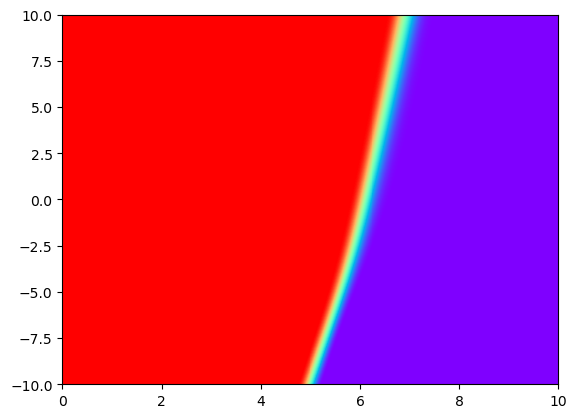

In [43]:
plt.imshow(u_pred_2.transpose(), interpolation='nearest', cmap='rainbow', 
                    extent=[T_2.min(), T_2.max(), X_2.min(), X_2.max()], 
                    origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
line = np.linspace(X_2.min(),X_2.max(), 2)[:,None]
    